# **Initial Imports**

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings("ignore")

## **Kaggle api to access datasets**

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gauravmalik26/food-delivery-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/food-delivery-dataset


In [22]:
import os

# List all files in the dataset directory
print(os.listdir(path))

# Load the CSV files
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))
expected_output = pd.read_csv(os.path.join(path, 'Sample_Submission.csv'))  # or the correct filename

['Sample_Submission.csv', 'train.csv', 'test.csv']


# **Data Preparation**

In [23]:
train.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [24]:
train.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

### **Handling Missing Values**

In [26]:
train.isna().any().sum() #no null values present

np.int64(0)

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [28]:
train.describe()

,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition
count,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000
mean,17.017729,70.231332,17.465186,70.845702,1.023359
std,8.185109,22.883647,7.335122,21.118812,0.839065
min,-30.905562,-88.366217,0.010000,0.010000,0.000000
25%,12.933284,73.170000,12.988453,73.280000,0.000000
50%,18.546947,75.898497,18.633934,76.002574,1.000000
75%,22.728163,78.044095,22.785049,78.107044,2.000000
max,30.914057,88.433452,31.054057,88.563452,3.000000


In [29]:
train['Delivery_person_Ratings'] = pd.to_numeric(train['Delivery_person_Ratings'], errors='coerce')
train['multiple_deliveries'] = pd.to_numeric(train['multiple_deliveries'], errors='coerce')
train['Delivery_person_Age'] = pd.to_numeric(train['Delivery_person_Age'], errors='coerce') # Added line

train['Order_Date'] = pd.to_datetime(train['Order_Date'], errors='coerce', dayfirst=True)
train['Time_Orderd'] = pd.to_datetime(train['Time_Orderd'], format='%H:%M:%S', errors='coerce').dt.time
train['Time_Order_picked'] = pd.to_datetime(train['Time_Order_picked'], format='%H:%M:%S', errors='coerce').dt.time

train['Weatherconditions'] = train['Weatherconditions'].str.replace('conditions ', '', regex=False)
train['City'] = train['City'].str.strip()

# Clean 'Time_taken(min)' column
train['Time_taken(min)'] = train['Time_taken(min)'].str.extract(r'(\d+)').astype(float) # Changed df to train

### **Handling Outliers**

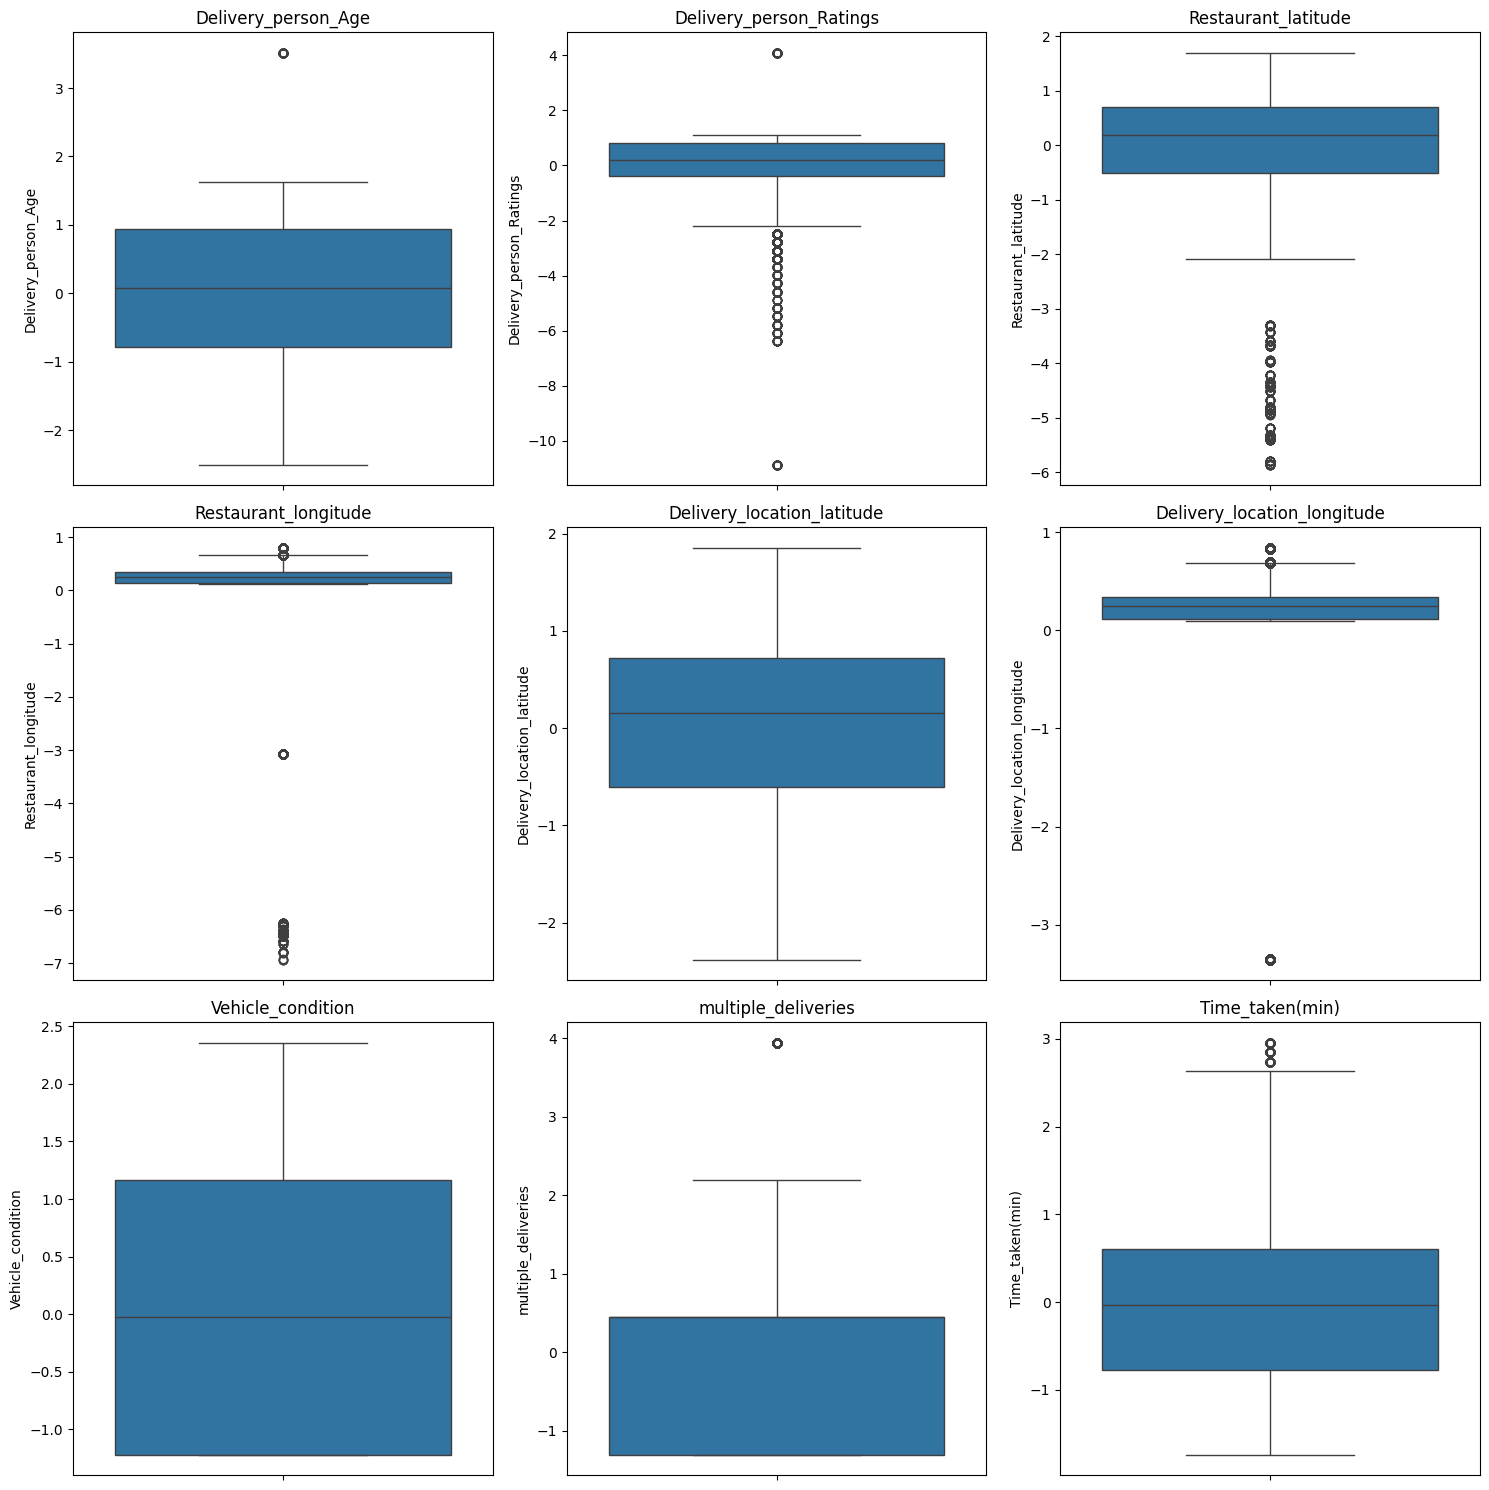

In [30]:
numerical_cols = train.select_dtypes(include=np.number).columns

n_cols = 3  # Number of columns in the subplot grid
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # Calculate number of rows needed

plt.figure(figsize=(15, n_rows * 5)) # Adjust figure size based on number of rows

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot((train[col] - train[col].mean()) / train[col].std())
    plt.title(col)

plt.tight_layout()
plt.show()

Number of outliers in Delivery_person_Age: 0


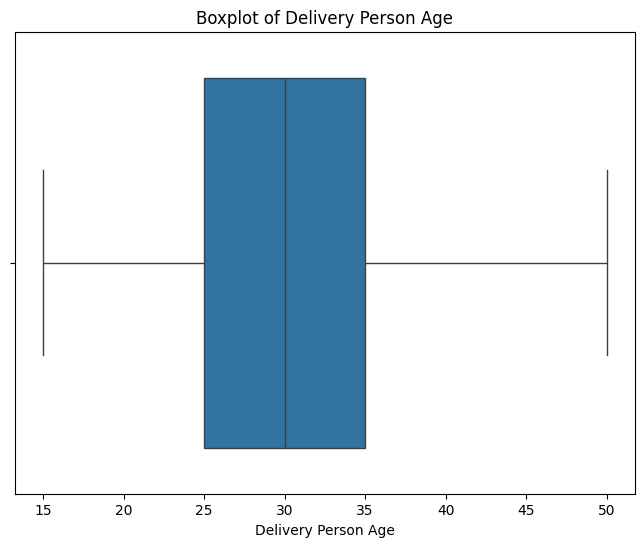

In [31]:
# Convert 'Delivery_person_Age' to numeric, coercing errors
train['Delivery_person_Age'] = pd.to_numeric(train['Delivery_person_Age'], errors='coerce')

# Drop rows where 'Delivery_person_Age' is NaN after coercion
train.dropna(subset=['Delivery_person_Age'], inplace=True)

# Calculate IQR for 'Delivery_person_Age'
Q1 = train['Delivery_person_Age'].quantile(0.25)
Q3 = train['Delivery_person_Age'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = train[(train['Delivery_person_Age'] < lower_bound) | (train['Delivery_person_Age'] > upper_bound)]

print(f"Number of outliers in Delivery_person_Age: {len(outliers)}")

# Visualize the distribution of 'Delivery_person_Age' with outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['Delivery_person_Age'])
plt.title('Boxplot of Delivery Person Age')
plt.xlabel('Delivery Person Age')
plt.show()

# to remove outliers:
train_cleaned = train[(train['Delivery_person_Age'] >= lower_bound) & (train['Delivery_person_Age'] <= upper_bound)]

# **Dropping Unwanted Columns**

In [32]:
train.drop(['ID'],axis=1,inplace=True)
train.drop(['Delivery_person_ID'],axis=1,inplace=True)
train.drop(['Order_Date'],axis=1,inplace=True)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43739 entries, 0 to 45592
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Delivery_person_Age          43739 non-null  float64
 1   Delivery_person_Ratings      43685 non-null  float64
 2   Restaurant_latitude          43739 non-null  float64
 3   Restaurant_longitude         43739 non-null  float64
 4   Delivery_location_latitude   43739 non-null  float64
 5   Delivery_location_longitude  43739 non-null  float64
 6   Time_Orderd                  43648 non-null  object 
 7   Time_Order_picked            43739 non-null  object 
 8   Weatherconditions            43739 non-null  object 
 9   Road_traffic_density         43739 non-null  object 
 10  Vehicle_condition            43739 non-null  int64  
 11  Type_of_order                43739 non-null  object 
 12  Type_of_vehicle              43739 non-null  object 
 13  multiple_deliveries  

In [34]:
train.shape

(43739, 17)

In [36]:
train.isna().sum()

,0
Delivery_person_Age,0
Delivery_person_Ratings,54
Restaurant_latitude,0
Restaurant_longitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Time_Orderd,91
Time_Order_picked,0
Weatherconditions,0
Road_traffic_density,0


In [42]:
train['Delivery_person_Ratings'].fillna(train['Delivery_person_Ratings'].mean(), inplace=True)
train['multiple_deliveries'].fillna(train['multiple_deliveries'].mode()[0], inplace=True)
train['Time_Orderd'].fillna(train['Time_Orderd'].mode()[0], inplace=True)


In [43]:
train.isna().sum()

,0
Delivery_person_Age,0
Delivery_person_Ratings,0
Restaurant_latitude,0
Restaurant_longitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Time_Orderd,0
Time_Order_picked,0
Weatherconditions,0
Road_traffic_density,0


In [45]:
train.shape

(43739, 17)

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43739 entries, 0 to 45592
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Delivery_person_Age          43739 non-null  float64
 1   Delivery_person_Ratings      43739 non-null  float64
 2   Restaurant_latitude          43739 non-null  float64
 3   Restaurant_longitude         43739 non-null  float64
 4   Delivery_location_latitude   43739 non-null  float64
 5   Delivery_location_longitude  43739 non-null  float64
 6   Time_Orderd                  43739 non-null  object 
 7   Time_Order_picked            43739 non-null  object 
 8   Weatherconditions            43739 non-null  object 
 9   Road_traffic_density         43739 non-null  object 
 10  Vehicle_condition            43739 non-null  int64  
 11  Type_of_order                43739 non-null  object 
 12  Type_of_vehicle              43739 non-null  object 
 13  multiple_deliveries  

In [47]:
train.describe()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition,multiple_deliveries,Time_taken(min)
count,43739.000000,43739.00000,43739.000000,43739.000000,43739.000000,43739.000000,43739.000000,43739.000000,43739.000000
mean,29.567137,4.63378,17.210960,70.661177,17.459031,70.821842,1.004733,0.748988,26.287387
std,5.815155,0.33451,7.764225,21.475005,7.342950,21.153148,0.820928,0.567763,9.368339
min,15.000000,1.00000,-30.902872,-88.366217,0.010000,0.010000,0.000000,0.000000,10.000000
25%,25.000000,4.50000,12.933298,73.170283,12.985996,73.280000,0.000000,0.000000,19.000000
50%,30.000000,4.70000,18.551440,75.898497,18.633626,76.002574,1.000000,1.000000,26.000000
75%,35.000000,4.90000,22.732225,78.045359,22.785049,78.104095,2.000000,1.000000,32.000000
max,50.000000,6.00000,30.914057,88.433452,31.054057,88.563452,3.000000,3.000000,54.000000
